In [113]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from matplotlib import pyplot as plt

In [114]:
# Calculates the "reward" (expected return) of a specific chess opening.
# Supported reward measures:
# "mean"    - Arithmetic mean
# "median"  - Median
# "mean_sq" - Mean squared
def reward_of_opening(measure: str, stats: List[int]) -> float:
    valid_measures = {"mean", "median", "mean_sq"}
    
    if measure not in valid_measures:
        raise ValueError(f"Invalid measure '{measure}'. Use one of: {valid_measures}")
    
    if measure == "mean":
        return np.mean(stats) 
    elif measure == "median":
        return np.median(stats)
    elif measure == "mean_sq":
        return np.mean(np.square(stats))

# Calculates the "risk" (volatility) of a specific chess opening.
# Supported risk measures:
# "std"     - Standard deviation (default)
# "sortino" - Sortino ratio (future implementation)
def risk_of_opening(measure: str, stats: List[int]) -> float:
    valid_measures = {"std", "sortino"}

    if measure not in valid_measures:
        raise ValueError(f"Invalid measure '{measure}'. Use one of: {valid_measures}")
    
    if measure == "std":
        return np.std(stats)

# Computes the covariance matrix of risks, assuming zero correlations.
# Here's explained why: 
# https://bookdown.org/compfinezbook/introcompfinr/risk-budgeting-using-portfolio-variance-and-portfolio-standard-deviation.
def calculate_covariances(risks: List[float]) -> np.ndarray:
    n = len(risks)
    covariance_matrix = np.zeros((n, n))
    for i in range(n):
        covariance_matrix[i, i] = risks[i] ** 2  # Variance of each opening
    return covariance_matrix

# Computes the expected return of a portfolio given weights and individual returns.
def calculate_portfolio_return(weights: np.ndarray, returns: np.ndarray) -> float:
    return np.dot(weights, returns)  # Weighted sum of individual returns

# Computes the total portfolio risk using the covariance matrix.
def calculate_portfolio_risk(weights: np.ndarray, covariance_matrix: np.ndarray) -> float:
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))  # Portfolio standard deviation

# Monte Carlo portfolio simulation
def run_portfolio_simulation(evaluated_openings: Dict[str, Tuple[float, float]], 
                             max_portfolio_size: int = 10, 
                             num_simulations: int = 100) -> List[Tuple[float, float, float, np.ndarray]]:
    """
    Runs a Monte Carlo simulation to generate random chess opening portfolios.
    
    - Ensures weights are chosen from a discrete range {0, step, 2*step, ..., 1}.
    - Limits portfolio size to max_portfolio_size openings.
    - Returns a sorted list of portfolios based on the Sharpe Ratio.

    :param evaluated_openings: Dictionary {opening_name: (reward, risk)}
    :param max_portfolio_size: Maximum number of openings in a portfolio
    :param num_simulations: Number of portfolio simulations
    :return: List of tuples [(risk, reward, sharpe_ratio, weights)]
    """
    openings = list(evaluated_openings.keys())
    rewards = np.array([evaluated_openings[op][0] for op in openings])
    risks = np.array([evaluated_openings[op][1] for op in openings])
    covariance_matrix = calculate_covariances(risks)  # Assume zero correlation

    step = 1 / max_portfolio_size  # Step size for weight allocation
    possible_weights = np.arange(0, 1 + step, step)  # Discrete weight choices
    portfolios = []
    seen = set()
    for _ in range(num_simulations):
        while True:
            # Select a random subset of openings (at most max_portfolio_size)
            selected_indices = np.random.choice(len(openings), size=max_portfolio_size, replace=False)
            
            # Randomly assign weights from discrete values
            weights = np.random.choice(possible_weights, size=max_portfolio_size, replace=True)
            
            if np.sum(weights) == 1:  # Ensure total weight sums to exactly 1
                break
        
        # Create a full weights array (zeros for unselected openings)
        full_weights = np.zeros(len(openings))
        full_weights[selected_indices] = weights
        
        # Compute portfolio statistics
        portfolio_return = calculate_portfolio_return(full_weights, rewards)
        portfolio_risk = calculate_portfolio_risk(full_weights, covariance_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk if portfolio_risk != 0 else 0
        
        weight_tuple = tuple(full_weights)

        if weight_tuple not in seen:
            portfolios.append((portfolio_risk, portfolio_return, sharpe_ratio, full_weights))
            seen.add(weight_tuple)
                
    # Sort portfolios by Sharpe Ratio (higher is better)
    portfolios.sort(key=lambda x: x[2], reverse=True)

    return portfolios


# Plots the Efficient Frontier: the set of optimal risk-return combinations.
def plot_efficient_frontier(portfolios_scores: List[Tuple[float, float]]):
    """
    Plots the Efficient Frontier using simulated portfolio scores.

    :param portfolios_scores: List of tuples [(risk, reward)]
    """
    # Unzip the portfolios_scores into risks and rewards
    risks, rewards = zip(*portfolios_scores)

    # Handle division by zero (avoid infinite Sharpe ratio)
    risks = np.array(risks)
    rewards = np.array(rewards)
    sharpe_ratios = np.divide(rewards, risks, where=risks != 0)  # Avoid division by zero
    
    # Create the figure and axis for plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for all portfolios
    plt.scatter(risks, rewards, c=sharpe_ratios, cmap="viridis", marker="o", edgecolors="black")
    
    # Highlight key portfolios: Max Sharpe Ratio and Minimum Variance Portfolio
    best_sharpe_idx = np.argmax(sharpe_ratios)  # Portfolio with max Sharpe ratio
    min_risk_idx = np.argmin(risks)  # Portfolio with min risk

    # Mark the max Sharpe ratio portfolio with a red star
    plt.scatter(risks[best_sharpe_idx], rewards[best_sharpe_idx], color='red', marker='*', s=200, label="Max Sharpe Ratio")
    
    # Mark the minimum variance portfolio with a blue diamond
    plt.scatter(risks[min_risk_idx], rewards[min_risk_idx], color='blue', marker='D', s=150, label="Min Variance Portfolio")
    
    # Labels and Title
    plt.xlabel("Risk (Standard Deviation)")
    plt.ylabel("Expected Reward")
    plt.title("Efficient Frontier of Chess Openings Portfolio")
    
    # Colorbar for Sharpe Ratios
    plt.colorbar(label="Sharpe Ratio")
    
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Retrieves the top X portfolios based on a chosen measure.
# Supported measures:
# "variance" - Selects portfolios with the lowest variance (risk minimization).
# "sharpe"   - Selects portfolios with the highest Sharpe Ratio.
def get_x_top_portfolios(evaluated_portfolios: List[Tuple], measure: str, x: int):
    valid_measures = {"variance", "sharpe"}

    if measure not in valid_measures:
        raise ValueError(f"Invalid measure '{measure}'. Use one of: {valid_measures}")
    
    if measure == "variance":
        sorted_portfolios = sorted(evaluated_portfolios, key=lambda p: p[0])  # Sort by lowest risk (variance)
    elif measure == "sharpe":
        sorted_portfolios = sorted(evaluated_portfolios, key=lambda p: p[2], reverse=True)  # Sort by highest Sharpe Ratio
    
    return sorted_portfolios[:x]  # Return top X portfolios

In [115]:
games = pd.read_csv("games.csv")

In [116]:
games

,id,utc_date,white,black,white_elo,black_elo,opening,cp_10,cp_11,cp_12,cp_13,cp_14,avg_opening_cp
0,1,2015.06.01,johnsama,vaske87,1559,1721,Owen Defense,35,48,47,50,276,91.2
1,2,2015.05.31,tropik,Drugon,1827,1915,Sicilian Defense,-2,13,-36,-43,56,-2.4
2,3,2015.05.31,blabla4u,erichon,1500,1442,Modern Defense,0,13,15,1,71,20.0
3,4,2015.05.31,jdefreitas,steve_mcqueen,2107,2100,Caro-Kann Defense: Breyer Variation,146,134,30,484,538,266.4
4,5,2015.05.31,mym56,jalrivi1952,1746,1672,Modern Defense: Standard Defense,122,171,207,386,222,221.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405,3406,2015.05.31,dukas225,nakafan2015,1460,2004,Horwitz Defense,-252,-285,-535,-567,-549,-437.6
3406,3407,2015.05.31,Lomotr,zatara,1353,1386,Nimzo-Larsen Attack: Modern Variation #3,-257,-229,-436,-544,-349,-363.0
3407,3408,2015.05.31,santamarta,franciscorm18,1765,1728,Sicilian Defense: Hyperaccelerated Dragon,-107,-176,-175,-51,-12,-104.2
3408,3409,2015.05.31,dionisio64,Berserkjairo,1774,1824,Philidor Defense #3,3,17,23,24,-15,10.4


In [117]:
games['opening_general'] = games['opening'].apply(lambda x: x.split()[0].lower() if isinstance(x, str) else x)

In [118]:
games

,id,utc_date,white,black,white_elo,black_elo,opening,cp_10,cp_11,cp_12,cp_13,cp_14,avg_opening_cp,opening_general
0,1,2015.06.01,johnsama,vaske87,1559,1721,Owen Defense,35,48,47,50,276,91.2,owen
1,2,2015.05.31,tropik,Drugon,1827,1915,Sicilian Defense,-2,13,-36,-43,56,-2.4,sicilian
2,3,2015.05.31,blabla4u,erichon,1500,1442,Modern Defense,0,13,15,1,71,20.0,modern
3,4,2015.05.31,jdefreitas,steve_mcqueen,2107,2100,Caro-Kann Defense: Breyer Variation,146,134,30,484,538,266.4,caro-kann
4,5,2015.05.31,mym56,jalrivi1952,1746,1672,Modern Defense: Standard Defense,122,171,207,386,222,221.6,modern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405,3406,2015.05.31,dukas225,nakafan2015,1460,2004,Horwitz Defense,-252,-285,-535,-567,-549,-437.6,horwitz
3406,3407,2015.05.31,Lomotr,zatara,1353,1386,Nimzo-Larsen Attack: Modern Variation #3,-257,-229,-436,-544,-349,-363.0,nimzo-larsen
3407,3408,2015.05.31,santamarta,franciscorm18,1765,1728,Sicilian Defense: Hyperaccelerated Dragon,-107,-176,-175,-51,-12,-104.2,sicilian
3408,3409,2015.05.31,dionisio64,Berserkjairo,1774,1824,Philidor Defense #3,3,17,23,24,-15,10.4,philidor


In [119]:
opening_counts = games['opening_general'].value_counts()


In [120]:
filtered_counts = opening_counts[opening_counts > 20]

In [121]:
len(filtered_counts)

37

Dla przykładu weźmy pod uwagę __Obronę Sycylijską__, oraz przedstawmy jej _ryzyko_, oraz _nagrodę_.

In [122]:
sicilian = games[games['opening_general'] == 'sicilian'] 

In [123]:
sicilian

,id,utc_date,white,black,white_elo,black_elo,opening,cp_10,cp_11,cp_12,cp_13,cp_14,avg_opening_cp,opening_general
1,2,2015.05.31,tropik,Drugon,1827,1915,Sicilian Defense,-2,13,-36,-43,56,-2.4,sicilian
11,12,2015.05.31,NMgornys,ZePequeno,1924,1962,Sicilian Defense: Delayed Alapin Variation,-27,-25,23,-10,-17,-11.2,sicilian
13,14,2015.05.31,olee,louisrobert,1421,1680,"Sicilian Defense: Smith-Morra Gambit Declined,...",-3,-214,-268,-371,-508,-272.8,sicilian
16,17,2015.05.31,tropik,Drugon,1827,1915,Sicilian Defense,-2,6,-39,-30,51,-2.8,sicilian
26,27,2015.05.31,NMgornys,ZePequeno,1924,1962,Sicilian Defense: Delayed Alapin Variation,-20,-27,33,-11,-13,-7.6,sicilian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,3398,2015.05.31,toonytoon72,moo,1719,1945,Sicilian Defense: Alapin Variation,-164,-387,-388,-493,-530,-392.4,sicilian
3399,3400,2015.05.31,Pantzes,lorychess,1262,1212,Sicilian Defense,-107,-29,93,111,36,20.8,sicilian
3401,3402,2015.05.31,va3101,elchuchesumare,1552,1370,Sicilian Defense: McDonnell Attack,-67,-44,-22,59,125,10.2,sicilian
3403,3404,2015.05.31,Iamspartacus,leko29,1453,1405,Sicilian Defense: Classical Variation,-4,-45,-43,-253,-307,-130.4,sicilian


In [124]:
eval_sicilian = list(sicilian['avg_opening_cp'])
reward = reward_of_opening("mean", eval_sicilian)
risk = risk_of_opening("std", eval_sicilian)

In [125]:
print(f"Reward of all variants of Sicilian Opening = {reward}") 
print(f"Risk of all variants of Sicilian Opening = {risk}")

Reward of all variants of Sicilian Opening = 12.357293868921776
Risk of all variants of Sicilian Opening = 238.6612576286488


In [126]:
opening_stats = games.groupby('opening_general')['avg_opening_cp'].agg(
    reward='mean', 
    risk='std'      
).reset_index()

In [127]:
opening_stats

,opening_general,reward,risk
0,alekhine,47.645714,228.045718
1,amazon,-490.000000,NaN
2,anderssen,-213.600000,NaN
3,barnes,110.200000,NaN
4,benko,119.133333,113.323650
...,...,...,...
84,vienna,87.255000,395.549373
85,wade,43.400000,25.455844
86,ware,249.366667,402.233493
87,yusupov-rubinstein,-11.600000,137.697349


In [128]:
opening_stats = opening_stats.dropna()

In [129]:
opening_stats

,opening_general,reward,risk
0,alekhine,47.645714,228.045718
4,benko,119.133333,113.323650
5,benoni,70.739130,154.127166
6,bird,32.973913,258.338533
7,bishop's,-8.871429,409.597628
...,...,...,...
84,vienna,87.255000,395.549373
85,wade,43.400000,25.455844
86,ware,249.366667,402.233493
87,yusupov-rubinstein,-11.600000,137.697349


In [130]:
top_5_low_risk = opening_stats.nsmallest(6, 'risk')
top_5_low_risk


,opening_general,reward,risk
85,wade,43.4,25.455844
9,blumenfeld,139.5,34.365390
61,pterodactyl,-31.4,47.234733
13,catalan,-22.3,51.053110
77,system:,88.4,59.679812
15,clemenz,-475.9,67.175144


In [131]:
top_5_high_reward = opening_stats.nlargest(6, 'reward')
top_5_high_reward


,opening_general,reward,risk
55,petrov:,298.200000,280.862813
54,petrov's,274.766667,283.558570
29,goldsmith,265.700000,219.061681
86,ware,249.366667,402.233493
33,gunderam,211.800000,72.124892
27,gedult's,177.800000,383.649215


Powyżej wyliczyliśmy Zysk oraz Nagrodę dla wszystkich otwarć bez podziału na warianty 

In [132]:
# Convert DataFrame to dictionary: {opening_name: (reward, risk)}
evaluated_openings = opening_stats.set_index('opening_general')[['reward', 'risk']].T.to_dict('list')

evaluated_openings

In [156]:
portfolios = run_portfolio_simulation(evaluated_openings, max_portfolio_size=5, num_simulations=50000)

portfolio są domyślnie posortowane względem sharpe ratio

In [157]:
portfolios

[(31.046854913179214,
  153.96,
  4.958956404136281,
  array([0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])),
 (35.46086293366252,
  168.42000000000002,
  4.749461408061821,
  array([0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])),

In [158]:
best_portfolio = np.where(portfolios[0][3] > 0)[0]
selected_openings_with_weights = [
    {"opening": opening_stats.iloc[i]["opening_general"], "weight": portfolios[0][3][i]}
    for i in best_portfolio
]
selected_openings_with_weights

[{'opening': 'blumenfeld', 'weight': 0.8},
 {'opening': 'gunderam', 'weight': 0.2}]

natomiast sprawdźmy jak wygląda to pod kątem ryzyka - portfele z najmneijszym ryzykiem

In [159]:
by_risk = sorted(portfolios, key=lambda x: x[0])

In [160]:
by_risk

[(20.548401397675686,
  81.84,
  3.982791576636091,
  array([0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. ])),
 (21.493236145355123,
  62.620000000000005,
  2.9134747125333536,
  array([0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. ]))

In [161]:
the_safest_portfolio = np.where(by_risk[0][3] > 0)[0]
selected_openings_with_weights = [
    {"opening": opening_stats.iloc[i]["opening_general"], "weight": by_risk[0][3][i]}
    for i in the_safest_portfolio
]
selected_openings_with_weights

[{'opening': 'blumenfeld', 'weight': 0.4},
 {'opening': 'wade', 'weight': 0.6000000000000001}]

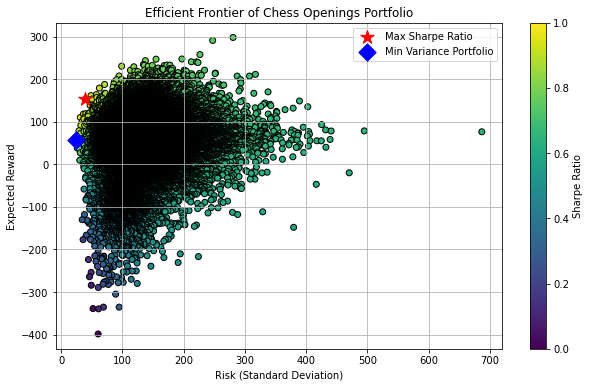

In [ ]:
portfolios_scores = [(portfolio[0], portfolio[1]) for portfolio in portfolios]
plot_efficient_frontier(portfolios_scores)

In [ ]:
len(portfolios_scores)

99996

In [151]:
def thesis_plot_efficient_frontier(portfolios_scores: List[Tuple[float, float]]):
    """
    Plots the Efficient Frontier using simulated portfolio scores in black and white for a thesis.

    :param portfolios_scores: List of tuples [(risk, reward)]
    """
    # Unzip the portfolios_scores into risks and rewards
    risks, rewards = zip(*portfolios_scores)

    # Handle division by zero (avoid infinite Sharpe ratio)
    risks = np.array(risks)
    rewards = np.array(rewards)
    sharpe_ratios = np.divide(rewards, risks, where=risks != 0)  # Avoid division by zero
    
    # Create the figure and axis for plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for all portfolios (black and white markers)
    scatter = plt.scatter(risks, rewards, c=sharpe_ratios, cmap="Greys", marker="o", edgecolors="black")
    
    # Highlight key portfolios: Max Sharpe Ratio and Minimum Variance Portfolio
    best_sharpe_idx = np.argmax(sharpe_ratios)  # Portfolio with max Sharpe ratio
    min_risk_idx = np.argmin(risks)  # Portfolio with min risk

    # Mark the max Sharpe ratio portfolio with a large black star
    plt.scatter(risks[best_sharpe_idx], rewards[best_sharpe_idx], color='black', marker='*', s=600, label="Max Sharpe Ratio", edgecolors='white', linewidths=2)
    
    # Mark the minimum variance portfolio with a large black diamond
    plt.scatter(risks[min_risk_idx], rewards[min_risk_idx], color='black', marker='D', s=200, label="Min Variance Portfolio", edgecolors='white', linewidths=2)
    
    # Labels and Title
    plt.xlabel("Ryzyko")
    plt.ylabel("Oczekiwana Nagroda")
    
    # Colorbar for Sharpe Ratios (grayscale)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Sharpe Ratio|")
    
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

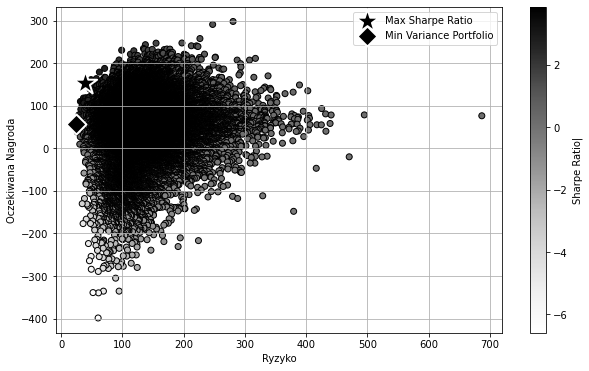

In [152]:
thesis_plot_efficient_frontier(portfolios_scores)